We fetch data from http://ai.stanford.edu/~amaas/data/sentiment/.

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six.moves import xrange, zip

%matplotlib inline

In [2]:
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

def review_to_wordlist(review, remove_stopwords=False):
    review_text = BeautifulSoup(review, 'lxml').get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return words

In [90]:
import re 
from six.moves import xrange
import os

def get_data(file_dirs, remove_stopwords=False):
    label = []
    txt = []
    comp_re = re.compile('(\d+)_(\d+).txt')
    for file_dir in file_dirs:
        name_list = [x for x in os.listdir(file_dir) if '.txt' in x]
        for x in iter(name_list):
            f = open(os.path.join(file_dir, x), 'r')
            # word_list = review_to_wordlist(f.read(),  remove_stopwords)
            txt.append(f.read())
            f.close()
            obj = comp_re.search(x)
            star = float(obj.group(2))
            if star > 5:
                label.append(1)
            else:
                label.append(0)
    return [txt, label]

In [29]:
%%time
train_unlabeled = get_data(['./aclImdb/train/unsup'], remove_stopwords=True)

CPU times: user 21.9 s, sys: 680 ms, total: 22.6 s
Wall time: 22.6 s


In [30]:
%%time
train_labeled = get_data(['./aclImdb/train/pos', './aclImdb/train/neg'], remove_stopwords=True)

CPU times: user 11.3 s, sys: 284 ms, total: 11.6 s
Wall time: 11.6 s


In [31]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 5000) 

In [32]:
def convert_data(data):
    new_data = []
    for x in data:
        new_data.append(' '.join(x))
    return new_data

In [34]:
from sklearn.preprocessing import normalize

def get_bow(vectorizer, data):
    data = convert_data(data)
    bow = vectorizer.transform(data)
    bow = normalize(bow, norm='l2', axis=1)
    return bow

In [36]:
%%time

vectorizer.fit(convert_data(train_labeled[0]))

CPU times: user 2.49 s, sys: 20 ms, total: 2.51 s
Wall time: 2.43 s


CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [37]:
bow = get_bow(vectorizer, train_labeled[0])

/home/tomoaki/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [11]:
from sklearn.preprocessing import normalize

bow = normalize(bow, norm='l2', axis=1)

/home/tomoaki/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [38]:
np.max(bow)

0.86692144686301076

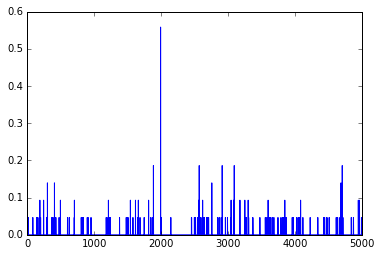

In [39]:
plt.plot(bow.toarray()[0])

In [59]:
%%time

from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 1000) 
forest.fit(bow, train_labeled[1])

CPU times: user 7min 1s, sys: 76 ms, total: 7min 1s
Wall time: 7min 1s


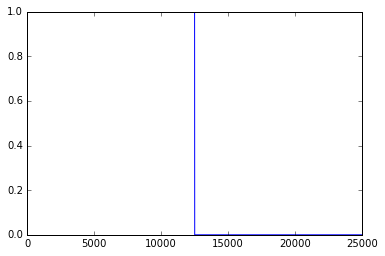

In [60]:
plt.plot(forest.predict(bow))

In [61]:
%%time
test_data = get_data(['./aclImdb/test/pos', './aclImdb/test/neg'], remove_stopwords=True)

CPU times: user 11.1 s, sys: 368 ms, total: 11.4 s
Wall time: 11.3 s


In [62]:
test_input, test_label = test_data
# vectorizer.fit([' '.join(x)  for x in labeled_data[0]])
test_bow = get_bow(vectorizer, test_input)

/home/tomoaki/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [63]:
output = forest.predict(test_bow)

In [64]:
def accuracy(prediction, target):
    return 1 - np.mean(np.abs(prediction - target))

# Neural Network

In [128]:
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def review_to_sentences(review, remove_stopwords=False):
    review = BeautifulSoup(review, 'lxml').get_text()
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentences) == 0:
            continue
        sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [92]:
%%time
train_unlabeled = get_data(['./aclImdb/train/unsup'], remove_stopwords=False)
train_labeled = get_data(['./aclImdb/train/pos', './aclImdb/train/neg'], remove_stopwords=False)

CPU times: user 392 ms, sys: 244 ms, total: 636 ms
Wall time: 639 ms


In [132]:
def get_sentnces(data):
    sentences = []
    labels = []
    ids = []
    for idx, x in enumerate(data[0]):
        _sentences = review_to_sentences(x)
        if len(_sentences) == 0:
            continue
        sentences += _sentences
        labels += [data[1][idx]] * len(_sentences)
        ids += [idx]*len(_sentences)
    return sentences, labels, ids

In [133]:
%%time
unlabeled_sentences, _, unlabeled_ids = get_sentnces(train_unlabeled)

CPU times: user 1min 45s, sys: 704 ms, total: 1min 46s
Wall time: 1min 46s


In [135]:
print(len(unlabeled_ids), len(unlabeled_sentences), len(_))

(539897, 539897, 539897)


In [136]:
import warnings

warnings.filterwarnings("ignore")

In [137]:
%%time
labeled_sentences, labeled_labels, labeled_ids = get_sentnces(train_labeled)

CPU times: user 52.4 s, sys: 260 ms, total: 52.6 s
Wall time: 52.6 s


In [145]:
%%time

from gensim.models.word2vec import Word2Vec

model = Word2Vec(unlabeled_sentences + labeled_sentences, size=100, 
                 window=5, min_count=5, workers=4, max_vocab_size=50000)

CPU times: user 2min 8s, sys: 1.4 s, total: 2min 9s
Wall time: 44.2 s


In [143]:
model.most_similar('woman')

[(u'girl', 0.8187841176986694),
 (u'lady', 0.7666571736335754),
 (u'man', 0.7453933358192444),
 (u'widow', 0.723605215549469),
 (u'prostitute', 0.7163055539131165),
 (u'person', 0.6789537668228149),
 (u'monk', 0.6728273630142212),
 (u'lad', 0.6556423306465149),
 (u'teenager', 0.6553688049316406),
 (u'nun', 0.6540654301643372)]

In [144]:
model.syn0.shape

(47167, 100)

In [148]:
vocab = dict([(k, v.index) for k, v in model.vocab.items()])

In [150]:
word_list = []
for x in labeled_sentences:
    word_list += x

In [153]:
%%time

def word2index(word):
    try:
        return vocab[word]
    except:
        return None
index = map(word2index, word_list)

CPU times: user 1.17 s, sys: 28 ms, total: 1.2 s
Wall time: 1.1 s


In [154]:
index

[87,
 823,
 135,
 10,
 9,
 5,
 0,
 4436,
 218,
 7,
 4515,
 11,
 348,
 16,
 585,
 9,
 16,
 5,
 2,
 220,
 260,
 35,
 0,
 366,
 1,
 1064,
 6,
 0,
 116,
 40,
 0,
 247,
 5963,
 21,
 46,
 19,
 508,
 35,
 2,
 16,
 1,
 46,
 19,
 508,
 35,
 4515,
 1216,
 4515,
 13,
 2,
 4006,
 19,
 49,
 27,
 1046,
 764,
 132,
 0,
 277,
 37,
 25,
 1148,
 7,
 2,
 2449,
 14,
 29,
 145,
 184,
 528,
 4881,
 499,
 1,
 4902,
 14,
 251,
 81,
 21,
 0,
 1314,
 3,
 2270,
 14,
 2,
 108,
 9592,
 130,
 134,
 2403,
 9849,
 21,
 170,
 100,
 46,
 14371,
 3956,
 4902,
 766,
 89,
 878,
 620,
 1682,
 2113,
 17,
 151,
 69,
 65,
 318,
 4687,
 107,
 3,
 89,
 125,
 71,
 25,
 814,
 61,
 631,
 5,
 3688,
 15,
 0,
 2143,
 3,
 0,
 108,
 0,
 0,
 5,
 260,
 35,
 193,
 6,
 5,
 63,
 4515,
 11,
 16,
 10,
 277,
 50,
 37,
 2,
 18,
 71,
 37,
 2,
 1548,
 3,
 765,
 4687,
 84,
 3,
 10,
 6,
 49,
 27,
 3292,
 4,
 6426,
 306,
 71,
 4515,
 11,
 432,
 258,
 37,
 34,
 2430,
 200,
 17,
 22,
 1048,
 1849,
 1946,
 523,
 0,
 0,
 3727,
 432,
 58,
 27,
 52,
 662,

In [147]:
weights = model.syn0
np.save(open("embbeding.npy", 'wb'), weights)

In [146]:
from keras.layers import Embedding, Input

def w2v_embedding_layer(embeddings_path):
    weights = np.load(open(embeddings_path, 'rb'))
    layer = Embedding(input_dim=weights.shape[0], 
                      output_dim=weights.shape[1], 
                      weights=[weights])
    return layer

Using TensorFlow backend.


In [70]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout, Reshape
from keras.layers import Embedding
from keras import backend as K
import numpy as np
import pandas as pd
import time
from gensim.models.word2vec import Word2Vec

class CNN(object):
    def __init__(self, conf, sentences):
        self.model_config = conf.model_config
        self.n_emb = conf.n_emb
        self.min_word_count = conf.min_word_count
        self.n_context = conf.n_context
        self.n_workers = 4
        self.algo = conf.algo
        self.n_epoch = conf.n_epoch
        self.batch_size = conf.batch_size
        
        print("build word2vec ...")
        self.word2vec = Word2Vec(sentences, workers=self.n_workers, 
            size=self.n_emb, min_count = self.min_word_count, 
            window = self.n_context, sg=self.algo)
        print("finished!")
        
        self.vocab = dict([(k, v.index) for k, v in self.word2vec.vocab.items()])
        self.n_vocab = len(self.vocab)
        self.maxlen = None
        index = self.word2index(sentences)
        self.maxlen = len(index[0])
        
        # avoid creating _LEARNING_PHASE outside the network
        tf.reset_default_graph()
        K.clear_session()
        self.sess = tf.Session()
        print("buiild model ...")
        self.build_model()
        print("finished")
        
    def train(self, input_data, target_data):
        print("start training")
        index_data = self.word2index(input_data)
        self.model.fit(index_data, target_data, nb_epoch=self.n_epoch, batch_size=self.batch_size)
        print("finished")
        
    def predict(self, input_data):
        index_data = self.word2index(input_data)
        return self.model.predict(index_data)
        
    def word2index(self, sentences):
        index = []
        for sentence in iter(sentences):
            index.append([self.vocab[w] for w in sentence if w in self.vocab.keys()])
        return pad_sequences(index, maxlen=self.maxlen)
    
    def build_model(self):
        self.input = tf.placeholder(tf.int32, [None, self.maxlen], name="input")
        self.model = self.build_cnn()
        self.output = self.model(self.input)
        self.model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
    
    def build_cnn(self):
        """Build network"""
        model = Sequential()
        # embedding
        model.add(Embedding(input_dim=self.n_vocab, output_dim=self.n_emb, 
                            input_length=self.maxlen, name="embedding", weights=[self.word2vec.syn0]))
        model.add(Reshape([self.maxlen, self.n_emb, 1]))
        # layer 1
        nf = self.n_feature
        model.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, 
                                border_mode='same', name="layer1"))
        model.add(BatchNormalization(mode=2, axis=-1))
        model.add(PReLU())
        model.add(MaxPooling2D(pool_size=(2, 1), strides=None))
        # layer2
        nf = nf * 2
        model.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, 
                                border_mode='same', name="layer2"))
        model.add(BatchNormalization(mode=2, axis=-1))
        model.add(PReLU())
        model.add(MaxPooling2D(pool_size=(2, 1), strides=None))
        model.add(Flatten())
        # layer3
        model.add(Dense(self.n_output, activation="sigmoid",
                       name="output_layer"))
        # model.add(BatchNormalization(mode=1, axis=-1))
        return model
        
        
        

In [83]:
class Config(object):
    device = '/gpu:0'
    save_path = '/home/tomoaki/work/github/jjakimoto.github.io/content'
    is_load = False
    n_batch = 32
    n_epoch = 10
    learning_rate = 1e-2
    n_emb = 100
    min_word_count = 10
    n_context = 10
    n_worker = 4
    algo = 1
    n_epoch=1
    batch_size = 64
    
    model_config = [{'type':'conv', 'n_feature': 32, 'kw': 4,
                    'activation': PReLU(), 'is_batch': True, 'is_drop': False,
                    'n_pool': 2},
                    {'type':'conv', 'n_feature': 64, 'kw': 4,
                    'activation': PReLU(), 'is_batch': True, 'is_drop': False,
                    'n_pool': 2},
                    {'type':'conv', 'n_feature': 32, 'kw': 4,
                     'activation': PReLU(), 'is_batch': True, 'is_drop': False,
                    'n_pool': 2},
                    {'type':'full', 'n_feature': 32, 'kw': 4,
                    'activation': PReLU(), 'is_batch': True, 'is_drop': False,
                    'n_pool': None},
                    {'type':'full', 'n_feature': 1, 'kw': 4,
                     'activation': Activation('sigmoid'), 'is_batch': False, 'is_drop': False,
                    'n_pool': None}]

In [85]:
target_data = train["sentiment"]
cnn = CNN(conf, sentences)
cnn.train(sentences, target_data)

build word2vec ...


KeyboardInterrupt: 

In [1]:
import sys


In [2]:
sys.path

['',
 '/Users/admin/pokemon/PokemonGo-Bot/src/pgoapi',
 '/Users/admin/anaconda/lib/python35.zip',
 '/Users/admin/anaconda/lib/python3.5',
 '/Users/admin/anaconda/lib/python3.5/plat-darwin',
 '/Users/admin/anaconda/lib/python3.5/lib-dynload',
 '/Users/admin/anaconda/lib/python3.5/site-packages',
 '/Users/admin/anaconda/lib/python3.5/site-packages/Sphinx-1.3.5-py3.5.egg',
 '/Users/admin/anaconda/lib/python3.5/site-packages/aeosa',
 '/Users/admin/anaconda/lib/python3.5/site-packages/IPython/extensions',
 '/Users/admin/.ipython']

In [3]:
!which python


/Users/admin/anaconda/bin/python


In [4]:
import os
os.environ['PYTHONPATH'].split(os.pathsep)

KeyError: 'PYTHONPATH'